# Text Generation 'Predicting the next word'

Welcome to this assignment! During this week you saw how to create a model that will predict the next word in a text sequence, now you will implement such model and train it using a corpus of Shakespeare's sonnets, while also creating some helper functions to pre-process the data.


Let's get started!

In [35]:
import numpy as np 
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical 
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional

We will be using the [Shakespeare Sonnets Dataset](https://www.opensourceshakespeare.org/views/sonnets/sonnet_view.php?range=viewrange&sonnetrange1=1&sonnetrange2=154), which contains more than 2000 lines of text extracted from Shakespeare's sonnets.

In [2]:
# sonnets.txt
!gdown --id 108jAePKK4R3BVYBbYJZ32JWUwxeMg20K

/usr/local/lib/python3.8/dist-packages/gdown/cli.py:127: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=108jAePKK4R3BVYBbYJZ32JWUwxeMg20K
To: /content/sonnets.txt
100% 93.6k/93.6k [00:00<00:00, 95.2MB/s]


In [3]:
# Define path for file with sonnets
SONNETS_FILE = './sonnets.txt'

# Read the data
with open('./sonnets.txt') as f:
    data = f.read()

# Convert to lower case and save as a list
corpus = data.lower().split("\n")

print(f"There are {len(corpus)} lines of sonnets\n")
print(f"The first 5 lines look like this:\n")
for i in range(5):
  print(corpus[i])

There are 2159 lines of sonnets

The first 5 lines look like this:

from fairest creatures we desire increase,
that thereby beauty's rose might never die,
but as the riper should by time decease,
his tender heir might bear his memory:
but thou, contracted to thine own bright eyes,


## Tokenizing the text

Now We'll fit the Tokenizer to the corpus and save the total number of words.

In [4]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index) + 1

In [5]:
corpus[0]

'from fairest creatures we desire increase,'

If we pass this text directly into the `texts_to_sequences` method we will get an unexpected result:

In [6]:
tokenizer.texts_to_sequences(corpus[0])

[[],
 [],
 [58],
 [],
 [],
 [],
 [17],
 [6],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [17],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [6],
 [],
 [],
 [],
 [6],
 [],
 [],
 [],
 [],
 [17],
 [],
 [],
 []]

This happened because `texts_to_sequences` expects a list and you are providing a string. However a string is still and `iterable` in Python so you will get the word index of every character in the string.

Instead we need to place the example whithin a list before passing it to the method:

In [7]:
tokenizer.texts_to_sequences([corpus[0]])

[[34, 417, 877, 166, 213, 517]]

In [8]:
tokenizer.texts_to_sequences([corpus[0]])[0]

[34, 417, 877, 166, 213, 517]

## Generating n_grams



In [20]:
# GRADED FUNCTION: n_gram_seqs
def n_gram_seqs(corpus, tokenizer):
    """
    Generates a list of n-gram sequences
    
    Args:
        corpus (list of string): lines of texts to generate n-grams for
        tokenizer (object): an instance of the Tokenizer class containing the word-index dictionary
    
    Returns:
        input_sequences (list of int): the n-gram sequences for each line in the corpus
    """
    input_sequences = []
    
    ### START CODE HERE
    for line in corpus:
      seq=tokenizer.texts_to_sequences([line])[0]
      for i in range(1,len(seq)):
        sub_seq=seq[:i+1]
        input_sequences.append(sub_seq)
    ### END CODE HERE
    
    return input_sequences

In [21]:
# Test your function with one example
first_example_sequence = n_gram_seqs([corpus[0]], tokenizer)

print("n_gram sequences for first example look like this:\n")
first_example_sequence

n_gram sequences for first example look like this:



[[34, 417],
 [34, 417, 877],
 [34, 417, 877, 166],
 [34, 417, 877, 166, 213],
 [34, 417, 877, 166, 213, 517]]

Apply the `n_gram_seqs` transformation to the whole corpus and save the maximum sequence length to use it later:

In [23]:
# Apply the n_gram_seqs transformation to the whole corpus
input_sequences = n_gram_seqs(corpus, tokenizer)

# Save max length 
max_sequence_len = max([len(x) for x in input_sequences])

print(f"n_grams of input_sequences have length: {len(input_sequences)}")
print(f"maximum length of sequences is: {max_sequence_len}")

n_grams of input_sequences have length: 15462
maximum length of sequences is: 11


## Add padding to the sequences



In [24]:
# GRADED FUNCTION: pad_seqs
def pad_seqs(input_sequences, maxlen):
    """
    Pads tokenized sequences to the same length
    
    Args:
        input_sequences (list of int): tokenized sequences to pad
        maxlen (int): maximum length of the token sequences
    
    Returns:
        padded_sequences (array of int): tokenized sequences padded to the same length
    """
    ### START CODE HERE
    padded_sequences = pad_sequences(input_sequences,padding='pre',truncating='pre',maxlen=maxlen)
    
    return padded_sequences
    ### END CODE HERE

In [27]:
# Pad the whole corpus
input_sequences = pad_seqs(input_sequences, max_sequence_len)

print(f"padded corpus has shape: {input_sequences.shape}")

padded corpus has shape: (15462, 11)


## Split the data into features and labels



In [32]:
# GRADED FUNCTION: features_and_labels
def features_and_labels(input_sequences, total_words):
    """
    Generates features and labels from n-grams
    
    Args:
        input_sequences (list of int): sequences to split features and labels from
        total_words (int): vocabulary size
    
    Returns:
        features, one_hot_labels (array of int, array of int): arrays of features and one-hot encoded labels
    """
    ### START CODE HERE
    features = input_sequences[:,:-1]
    labels = input_sequences[:,-1]
    one_hot_labels = to_categorical(labels,num_classes=total_words)
    ### END CODE HERE

    return features, one_hot_labels

In [34]:
# Split the whole corpus
features, labels = features_and_labels(input_sequences, total_words)

print(f"features have shape: {features.shape}")
print(f"labels have shape: {labels.shape}")

features have shape: (15462, 10)
labels have shape: (15462, 3211)


## Create the model



In [58]:
# GRADED FUNCTION: create_model
def create_model(total_words, max_sequence_len):
    """
    Creates a text generator model
    
    Args:
        total_words (int): size of the vocabulary for the Embedding layer input
        max_sequence_len (int): length of the input sequences
    
    Returns:
        model (tf.keras Model): the text generator model
    """
    model = Sequential()
    ### START CODE HERE
    model.add(Embedding(total_words, 100, input_length=max_sequence_len-1))
    model.add(Bidirectional(LSTM(100)))
    model.add(Dense(total_words,activation='softmax'))
    


    # Compile the model
    model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                  optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9, momentum=0),
                  metrics=['accuracy'])
    
    ### END CODE HERE

    return model

In [64]:
# Get the untrained model
model = create_model(total_words, max_sequence_len)
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.000001, rho=0.9, momentum=0),
              metrics=['accuracy'])
# Train the model
history = model.fit(features, labels, epochs=200, verbose=1)

Epoch 1/5
484/484 [==============================] - 8s 10ms/step - loss: 0.5915 - accuracy: 0.8656
Epoch 2/5
484/484 [==============================] - 4s 8ms/step - loss: 0.5915 - accuracy: 0.8656
Epoch 3/5
484/484 [==============================] - 4s 9ms/step - loss: 0.5915 - accuracy: 0.8656
Epoch 4/5
484/484 [==============================] - 4s 8ms/step - loss: 0.5914 - accuracy: 0.8656
Epoch 5/5
484/484 [==============================] - 4s 8ms/step - loss: 0.5914 - accuracy: 0.8656


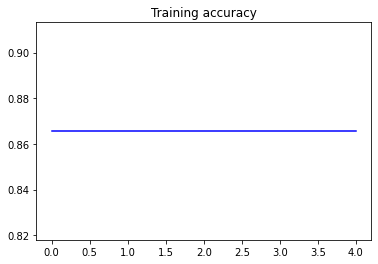

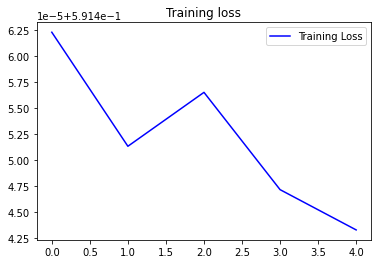

In [65]:
# Take a look at the training curves of your model

acc = history.history['accuracy']
loss = history.history['loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.title('Training accuracy')

plt.figure()

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training loss')
plt.legend()

plt.show()

In [66]:
def download_history():
  import pickle
  from google.colab import files

  with open('history.pkl', 'wb') as f:
    pickle.dump(history.history, f)

  files.download('history.pkl')

download_history()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## See our model in action

After all our work it is finally time to see our model generating text. 



In [67]:
seed_text = "Help me Obi Wan Kenobi, you're my only hope"
next_words = 100
  
for _ in range(next_words):
	# Convert the text into sequences
	token_list = tokenizer.texts_to_sequences([seed_text])[0]
	# Pad the sequences
	token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
	# Get the probabilities of predicting a word
	predicted = model.predict(token_list, verbose=0)
	# Choose the next word based on the maximum probability
	predicted = np.argmax(predicted, axis=-1).item()
	# Get the actual word from the word index
	output_word = tokenizer.index_word[predicted]
	# Append to the current text
	seed_text += " " + output_word

print(seed_text)

Help me Obi Wan Kenobi, you're my only hope but as be groan free bewailed lies walls entombed foes men's 'no ' ' sometime sought wanting ' had comment eisel grounded fresher lascivious salutation again ' grown ruin'd ' expressing themes unfair fearfully blame renew another's lies ' lascivious five ' bail unfair free thanks shadows slander'd shake chide the grown grounded waves ages ' consent ' thy horse ye nought silent thee confounding ' must less long wanting ' wail presagers ' lascivious suspect fearfully patience again upon blood renew viewest shake ' knows renew built writes slander'd wail public unkind alive their yours ' loveliness heaven's '
